# QSAR modelling of estrogen receptor alpha ligands

This notebook features a workflow that tries to extract activity-structure information from experimental data. 


## Data Aquisition and Preprocessing

The data are saved in the database (DB) and can be loaded into a [pandas](http://pandas.pydata.org) data frame using the [`compound_db_utils`](https://github.com/martin-sicho/MI_ADM/tree/master/compound_db_utils) package:

In [1]:
import os, pickle, math

from compound_db_utils import settings
from compound_db_utils.data_loaders import fetch_learning_data

RELOAD = False # if True, ignore the pickled data and update from DB

def remove_inconsistent(smiles, ic50s):
    """
    Filter that computes a consensus value for molecules that were tested
    multiple times. The consensus is computed as the median of all 
    available values. 
    
    Molecules with too much variation in the data 
    and too few data points are marked as inconsistent and
    removed entirely.
    """
    
    if int(math.log(ic50s.min(), 10)) != int(math.log(ic50s.max(), 10)) and len(ic50s) < 20:
        return False
    else:
        return ic50s.median()

data = None
if os.path.exists('data.pickle') and not RELOAD:
    data = pickle.load(open('data.pickle', 'br'))
else:
    data = fetch_learning_data(
                ['MI-T-15c25ba4']
                , col_names_map={
                    settings.COMPOUNDS_TABLE + '_smiles' : 'smiles'
                    , settings.BIOACTIVITIES_TABLE + '_value' : 'ic50'
                }
                , create_rdkit_mols=False
                , compute_descriptors=True
                , duplicates_handler= remove_inconsistent
            )
    
pickle.dump(data, open('data.pickle', 'bw'))    

/home/sichom/software/miniconda/envs/MI_ADM/lib/python3.5/site-packages/rdkit/Chem/PeriodicTable.py:131: FutureWarning: split() requires a non-empty pattern match.
  splitLine = blankExpr.split(line)


For each compound, the loaded data provide the canonical [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) string and measured [IC50](https://en.wikipedia.org/wiki/IC50) values. We also chose to compute molecular descriptors for the compounds. Those are saved in the remaining columns (descriptors are computed using the [RDKit](https://rdkit.readthedocs.io/en/latest/) cheminformatics toolkit).

Note that the original dataset may contain duplicate entries, because more experiments were often carried out for one given compound. Here, we decided to remove compounds that show large inconsistencies in their IC50 values and we do not have enough data to safely aggregate the values together.

Because now we only have one SMILES string for each compound, we can use them as the index of the data frame:

In [2]:
# data.set_index('smiles', inplace=True)
print(data.shape)
data.head(10)

(1327, 198)


,ic50,smiles,MaxAbsPartialCharge,MaxAbsEStateIndex,MinPartialCharge,NumValenceElectrons,MaxPartialCharge,MinAbsPartialCharge,MinEStateIndex,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,31.055,CC(C)c1cccc(N2CCc3cc(O)ccc3C2(C)c2ccc(OCCN3CCCCC3)cc2)c1,0.507956,10.188795,-0.507956,190,0.118883,0.118883,-0.357919,484.308979,...,0,0,0,0,0,0,0,0,0,0
2,4.700,CCc1c(O)ccc2c1O[C@H](c1ccc(OCCN3CCCCC3)cc1)[C@H](c1ccc(O)cc1)S2,0.507967,10.412779,-0.507967,184,0.140270,0.140270,-0.243942,491.213030,...,1,0,0,0,0,0,0,0,0,0
3,24.800,Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,0.507956,13.740342,-0.507956,184,0.243451,0.243451,-3.728670,492.208279,...,0,1,0,0,0,0,0,0,0,0
4,6.000,CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,0.507966,12.401821,-0.507966,94,0.194032,0.194032,-0.043343,252.078644,...,0,0,0,0,0,0,0,0,0,0
5,35.000,Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,0.507920,9.863330,-0.507920,162,0.143093,0.143093,-0.198525,437.166079,...,1,0,0,0,0,0,0,0,0,0
8,1260.000,O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,0.507895,12.512773,-0.507895,110,0.239157,0.239157,-0.558945,361.942600,...,0,0,0,0,0,0,0,0,0,0
9,1727.000,Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,0.507943,9.724977,-0.507943,102,0.170701,0.170701,0.139596,277.073893,...,0,0,0,0,0,0,0,0,0,0
10,114.000,Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,0.507966,9.552571,-0.507966,90,0.137489,0.137489,0.225635,240.078644,...,0,0,0,0,0,0,0,0,0,0
11,527.000,C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,0.507921,13.477906,-0.507921,104,0.164917,0.164917,-0.650697,280.089958,...,0,0,0,0,0,0,0,0,0,0
12,2.200,OCC1CCN(CCOc2ccc([C@@H]3Oc4ccc(O)cc4S[C@@H]3c3ccc(O)cc3)cc2)CC1,0.507967,9.943080,-0.507967,184,0.140005,0.140005,-0.232911,493.192294,...,1,0,0,0,0,0,0,0,0,0


Next, we convert the IC50 values to pIC50 which is defined as the negative logarithm with base 10 of the concentration in moles rather than nanomoles (the default unit for the data in our database): 

In [3]:
import numpy as np

data.ic50 = data.ic50.apply(lambda x : -1.0 * np.log10(x / 1.0e9))

Because of the logarithmic scale, the converted data are now much 'nicer' (note that the higher the pIC50 value, the more potent the compound is as opposed to the raw IC50 value where lower value means higher potency):

Original:
count       1327.000000
mean       12345.786545
std       126395.212707
min            0.200000
25%           55.500000
50%          625.000000
75%         7308.305000
max      3500000.000000
Name: ic50, dtype: float64

Converted:
count    1327.000000
mean        6.295696
std         1.359669
min         2.455932
25%         5.136184
50%         6.204120
75%         7.255725
max         9.698970
Name: ic50, dtype: float64


[]

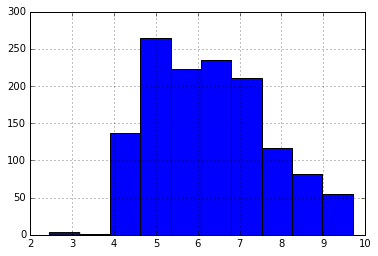

In [4]:
%matplotlib inline
print('Original:')
print(data.ic50.apply(lambda x : np.power(10, - x) * 1.0e9).describe())
print('\nConverted:')
print(data.ic50.describe())
data.ic50.hist().plot()

In this experiment, we will be using [h2o](http://www.h2o.ai/) for Python to build the model. Therefore, we initialize the `h2o` module and upload our data to the H2O cluster:

In [5]:
import h2o

from h2o.frame import H2OFrame

h2o.init()
h2o.h2o.remove_all()

frame = H2OFrame.from_python(
    python_obj=data
    , destination_frame="data_all"
    , column_names=data.columns.get_values().tolist()
    , header=1
)
frame.head(10)

Connecting to H2O server at http://localhost:54321... successful!


H2O cluster uptime:,36 secs
H2O cluster version:,3.10.0.3
H2O cluster version age:,20 hours and 26 minutes
H2O cluster name:,sichom
H2O cluster total nodes:,1
H2O cluster free memory:,1.696 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster is healthy:,True
H2O cluster is locked:,False
H2O connection url:,http://localhost:54321


ic50,smiles,MaxAbsPartialCharge,MaxAbsEStateIndex,MinPartialCharge,NumValenceElectrons,MaxPartialCharge,MinAbsPartialCharge,MinEStateIndex,ExactMolWt,MaxEStateIndex,MinAbsEStateIndex,HeavyAtomMolWt,MolWt,NumRadicalElectrons,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
7.50787,CC(C)c1cccc(N2CCc3cc(O)ccc3C2(C)c2ccc(OCCN3CCCCC3)cc2)c1,0.507956,10.1888,-0.507956,190,0.118883,0.118883,-0.357919,484.309,10.1888,0.33686,444.364,484.684,0,1.4361,1167.03,25.1227,22.0421,22.0421,17.4465,13.6062,13.6062,10.8401,10.8401,8.14777,8.14777,5.96487,5.96487,-2.98,1.74799e+08,24.7028,10.5583,4.96717,216.071,14.7433,18.1059,0,0,0,0,4.89991,0,0,0,50.6001,103.846,18.7769,5.53893,9.84339,5.68739,0,4.89991,0,57.9113,37.6858,88.9838,0,11.499,9.63677,5.68739,11.499,0,42.7923,11.9597,0,68.2054,66.73,0,0,0,35.94,0,5.10653,0,5.53893,11.6674,31.8667,60.2932,0,12.1327,85.1683,4.73686,0,0,0,0,0,0,0,0,0,69.25,0.4375,36,1,4,0,2,2,3,0,3,4,1,4,7,0,1,1,5,6.7065,148.37,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8.3279,CCc1c(O)ccc2c1O[C@H](c1ccc(OCCN3CCCCC3)cc1)[C@H](c1ccc(O)cc1)S2,0.507967,10.4128,-0.507967,184,0.14027,0.14027,-0.243942,491.213,10.4128,0.00298043,458.389,491.653,0,1.36849,1126.67,24.2001,20.9679,20.9679,17.1185,13.4228,13.4228,10.4157,10.4157,8.23081,8.23081,6.25401,6.25401,-2.83,1.29129e+08,23.8906,10.8357,5.3865,211.247,19.6868,35.7089,0,0,0,0,4.89991,0,0,0,37.61,79.8771,12.1082,22.8529,19.6868,0,0,4.89991,0,48.8564,26.2412,77.354,0,22.998,9.47373,0,22.998,0,41.3541,6.42082,0,54.2305,65.5592,0,0,0,62.16,0,10.2131,0,22.8529,13.0277,39.6296,32.352,0,37.2556,17.0326,9.47373,0,0,0,0,0,0,0,0,0,71.0968,0.37931,35,1,6,0,1,1,3,0,3,6,1,6,7,0,1,1,5,6.492,139.787,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0

## Model Building

Now that the dataset is ready, we split the data frame into a training and testing set:

In [6]:
training_frame, testing_frame =  frame.split_frame(
    ratios=[0.6]
    , destination_frames=["data_all_train", "data_all_test"]
    , seed=42
)
print(training_frame.shape, testing_frame.shape)

(811, 198) (516, 198)


and we train a Random Forest Estimator on the training set:

In [7]:
from h2o.estimators.random_forest import H2ORandomForestEstimator as RFE

model = RFE(
    model_id = "random_forest_model"
#    , mtries=-1
#    , sample_rate=0.666
#    , sample_rate_per_class=[]
#    , col_sample_rate_per_tree=1
#    , col_sample_rate_change_per_level=1
#    , build_tree_one_node=False
#    , ntrees=50
#    , max_depth=20
#    , min_rows=1
#    , nbins=20
#    , nbins_cats=1024
#    , binomial_double_trees=False
#    , balance_classes=False
    , seed=42
    , nfolds=5
    , fold_assignment="Random"
#    , keep_cross_validation_predictions=False
#    , keep_cross_validation_fold_assignment=False
#    , score_each_iteration=False
#    , score_tree_interval=0
#    , stopping_rounds=0
#    , stopping_metric="AUTO"
#    , stopping_tolerance=0.001
#    , min_split_improvement=0
#    , histogram_type="AUTO"
)
model.train(
    x=training_frame.names[2:]
    , y='ic50'
    , training_frame=training_frame
)
model.show()


Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  random_forest_model

Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,313083.0,16.0,20.0,19.44,443.0,516.0,492.82




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.5596715307493105
RMSE: 0.7481119774133486
MAE: 0.5467097735097327
Mean Residual Deviance: 0.5596715307493105

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.5524110895898509
RMSE: 0.7432436273456039
MAE: 0.545925952138795
Mean Residual Deviance: 0.5524110895898509

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mse,0.5513650,0.0596757,0.4445787,0.5550931,0.4684088,0.6468611,0.6418830
r2,0.7084863,0.0269139,0.7508702,0.7023795,0.7538244,0.6711293,0.664228
residual_deviance,0.5513650,0.0596757,0.4445787,0.5550931,0.4684088,0.6468611,0.6418830
rmse,0.740334,0.0404386,0.6667674,0.7450457,0.6844040,0.8042768,0.801176



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2016-08-02 14:50:11,27.695 sec,0.0,nan,nan,nan
,2016-08-02 14:50:11,27.883 sec,1.0,1.0129233,0.7066901,1.0260135
,2016-08-02 14:50:11,28.020 sec,2.0,1.0122430,0.7094823,1.0246359
,2016-08-02 14:50:11,28.157 sec,3.0,0.9715877,0.7010044,0.9439826
,2016-08-02 14:50:11,28.279 sec,4.0,1.0078964,0.7297921,1.0158552
---,---,---,---,---,---,---
,2016-08-02 14:50:14,31.310 sec,27.0,0.7645059,0.5537443,0.5844692
,2016-08-02 14:50:14,31.438 sec,28.0,0.7663875,0.5560638,0.5873497
,2016-08-02 14:50:14,31.568 sec,29.0,0.7630462,0.5550810,0.5822395
,2016-08-02 14:50:15,31.686 sec,30.0,0.7630318,0.5554305,0.5822175



See the whole table with table.as_data_frame()

Variable Importances: 


variable,relative_importance,scaled_importance,percentage
MinPartialCharge,8379.7832031,1.0,0.1488039
MaxAbsPartialCharge,7364.1694336,0.8788019,0.1307692
MolMR,2754.5798340,0.3287173,0.0489144
NumAromaticCarbocycles,2347.3395996,0.2801194,0.0416829
fr_benzene,2277.1430664,0.2717425,0.0404364
---,---,---,---
fr_term_acetylene,0.0,0.0,0.0
fr_thiocyan,0.0,0.0,0.0
fr_thiophene,0.0,0.0,0.0
fr_unbrch_alkane,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [19]:
importances = model.varimp(use_pandas=True)
pickle.dump(importances, open('importances_rf.pickle', 'bw'))
importances.head()

,variable,relative_importance,scaled_importance,percentage
0,MinPartialCharge,8379.783203,1.000000,0.148804
1,MaxAbsPartialCharge,7364.169434,0.878802,0.130769
2,MolMR,2754.579834,0.328717,0.048914
3,NumAromaticCarbocycles,2347.339600,0.280119,0.041683
4,fr_benzene,2277.143066,0.271742,0.040436


### Cross-validation Results

In [8]:
model.model_performance(xval=True)


ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.5524110895898509
RMSE: 0.7432436273456039
MAE: 0.545925952138795
Mean Residual Deviance: 0.5524110895898509


### Validation Set Results

In [9]:
model.model_performance(test_data=testing_frame)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.40653145346367814
RMSE: 0.6375981912330666
MAE: 0.47801433401514337
Mean Residual Deviance: 0.40653145346367814


### Error plots

Finally, we take a look at the distribution of errors in predictions among the training set and the test set:

In [10]:
predictions_train = model.predict(training_frame).as_data_frame()
predictions_test = model.predict(testing_frame).as_data_frame()
predictions_train.columns = ['ic50']
predictions_test.columns = ['ic50']
true_values_train = training_frame['ic50'].as_data_frame()
true_values_test = testing_frame['ic50'].as_data_frame()

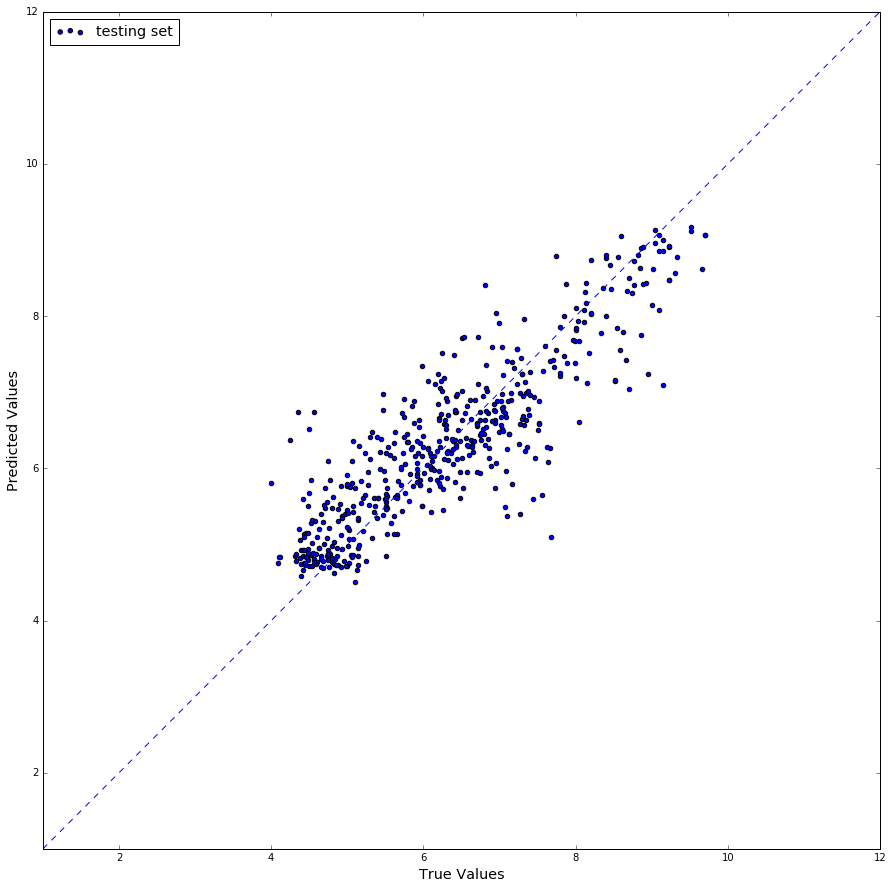

In [12]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 15]
span = (1,12)
axes = plt.gca()
axes.set_xlim(span)
axes.set_ylim(span)
axes.set_xlabel("True Values", fontsize='x-large')
axes.set_ylabel("Predicted Values", fontsize='x-large')

plt.plot((span[0],span[1]), (span[0],span[1]), linestyle='--')

# plt.scatter(
#     true_values_train
#     , predictions_train
#     , c='green'
#     , s=20
#     , label='training set'
# )

plt.scatter(
    true_values_test
    , predictions_test
    , c='blue'
    , s=20
    , label='testing set'
)

plt.legend(loc='upper left', fontsize='x-large')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcaee381dd8>]], dtype=object)

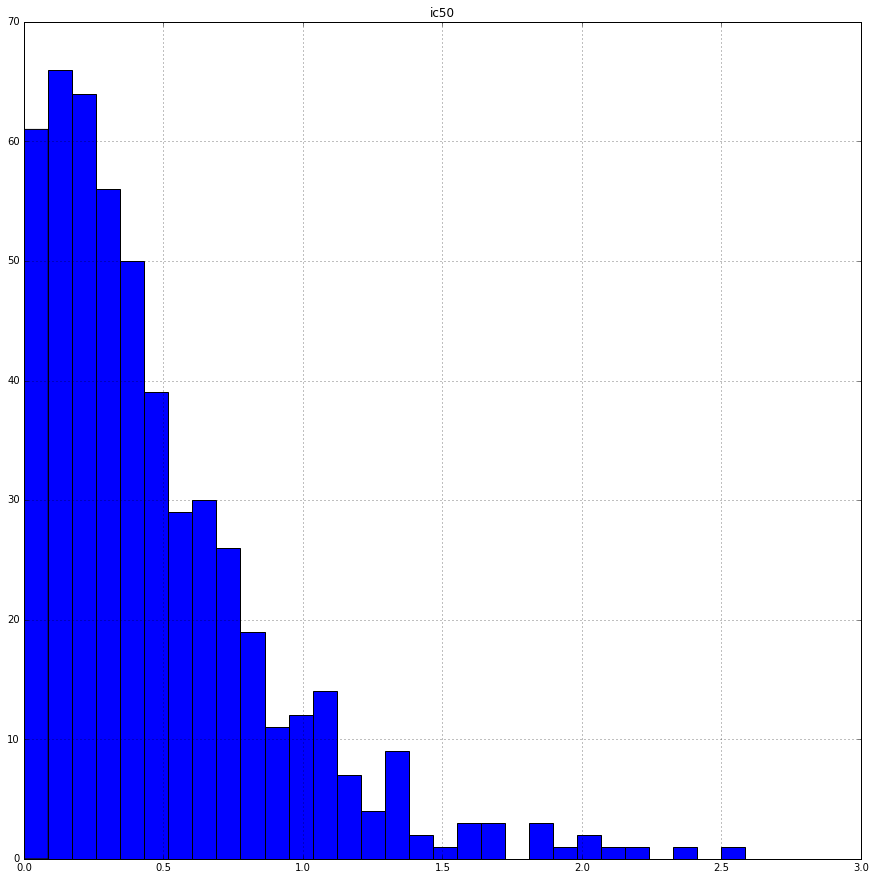

In [13]:
(true_values_test - predictions_test).abs().hist(bins=30)

## PCA Analysis

We can extract features that proved to be of high importance in the decision tree building, thus, should be most relevant to the activity-structure relationship. and project the molecules to 3D space and see if there is any correlation between their postion and the pIC50 value:

In [14]:
importances = model.varimp(use_pandas=True)
mask = (importances["scaled_importance"] * 100) > 10
descs_important = data[importances["variable"][mask]]
print(descs_important.shape)
descs_important.head(10)

(1327, 15)


,MinPartialCharge,MaxAbsPartialCharge,MolMR,NumAromaticCarbocycles,fr_benzene,NumAromaticRings,MaxPartialCharge,MolLogP,BalabanJ,Chi4n,Chi4v,TPSA,MinAbsPartialCharge,SlogP_VSA1,Chi0n
0,-0.507956,0.507956,148.3698,3,3,3,0.118883,6.70650,1.436100,5.964871,5.964871,35.94,0.118883,9.636773,22.042053
2,-0.507967,0.507967,139.7866,3,3,3,0.140270,6.49200,1.368494,4.925974,6.254014,62.16,0.140270,9.473726,20.151443
3,-0.507956,0.507956,136.3356,3,3,3,0.243451,4.51162,1.434939,5.085865,6.681140,70.08,0.243451,4.736863,20.059691
4,-0.507966,0.507966,73.0321,2,2,2,0.194032,3.22480,2.183659,2.455828,2.455828,57.53,0.194032,0.000000,10.344127
5,-0.507920,0.507920,121.0098,2,2,3,0.143093,5.81700,1.294169,4.215985,5.497220,55.07,0.143093,9.473726,17.405371
8,-0.507895,0.507895,82.4564,2,2,4,0.239157,3.57170,2.328321,2.491855,3.020916,104.04,0.239157,5.428790,10.753751
9,-0.507943,0.507943,80.2806,3,3,4,0.170701,4.05920,2.063442,2.587569,2.587569,66.49,0.170701,0.000000,10.946041
10,-0.507966,0.507966,69.7166,2,2,3,0.137489,3.81942,2.188698,2.076821,2.076821,53.60,0.137489,0.000000,9.844127
11,-0.507921,0.507921,82.7626,3,3,3,0.164917,4.70010,2.223360,2.405112,2.405112,40.46,0.164917,0.000000,11.175651
12,-0.507967,0.507967,136.3674,3,3,3,0.140005,5.14800,1.268789,4.672000,5.996176,82.39,0.140005,9.473726,19.546250


In [15]:
from sklearn import decomposition

n_components=5

pca = decomposition.PCA(n_components=n_components)
pca.fit(descs_important)
pca_result = pca.transform(descs_important)
eigen_values = pca.explained_variance_ratio_

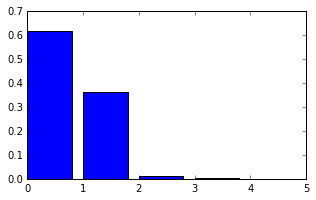

In [16]:
plt.rcParams["figure.figsize"] = [5, 3]

plt.bar(range(pca_result.shape[1]), eigen_values)
plt.show()

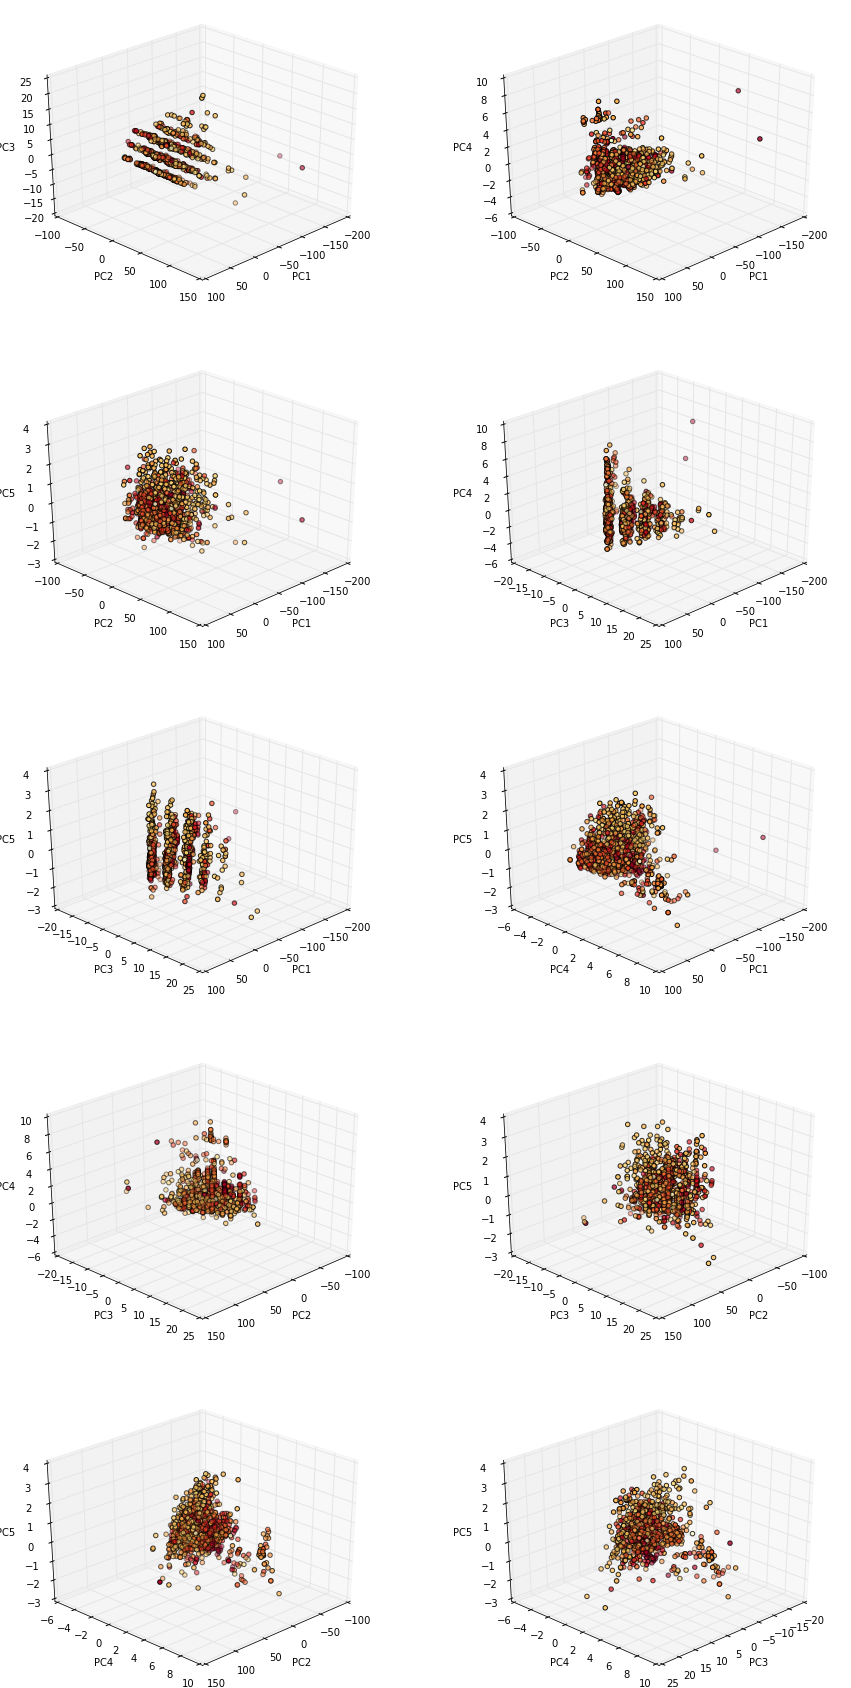

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

combos = list(combinations(range(n_components), 3))

plt.rcParams["figure.figsize"] = [15, 30]
fig = plt.figure(len(combos) / 2)

for idx, combo in enumerate(combos):
    ax = fig.add_subplot(len(combos) / 2, 2, idx + 1, projection='3d')
    ax.scatter(
        pca_result[:,combo[0]]
        , pca_result[:,combo[1]]
        , pca_result[:,combo[2]]
        , c=data.ic50
        , s=20
        , cmap='YlOrRd' # red are the compounds with higher values of pIC50
    )
    ax.view_init(elev=30, azim=45)
    ax.set_xlabel('PC%s' % (combo[0] + 1))
    ax.set_ylabel('PC%s' % (combo[1] + 1))
    ax.set_zlabel('PC%s' % (combo[2] + 1))

plt.show()